# Introductory applied machine learning (INFR10069)

# Assignment 3: Object recognition

## Marking Breakdown

**70-100%** results/answer correct plus extra achievement at understanding or analysis of results. Clear explanations, evidence of creative or deeper thought will contribute to a higher grade.

**60-69%** results/answer correct or nearly correct and well explained.

**50-59%** results/answer in right direction but significant errors.

**40-49%** some evidence that the student has gained some understanding, but not answered the questions
properly.

**0-39%** serious error or slack work.

## Mechanics

Fill out this notebook, save it, and submit it **and a `.txt` file** (see Part 2) in answer to this assignment.
**You need to submit these two files electronically as described below.**

On a DICE environment, open the terminal, navigate to the location of this notebook, and submit this notebook file using the following command:

`submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt`

What actually happens in the background is that your file is placed in a folder available to markers. If you submit a file with the same name into the same location, **it will *overwrite* your previous submission**. You can check the status of your submissions with the `show_submissions` command.

**Distance Learners:** To copy your work up to DICE (such that you can use the `submit` command) you can use `scp` or `rsync` (you may need to install these yourself). You can copy files up using `student.ssh.inf.ed.ac.uk`, then ssh in to submit, e.g. (in a unix terminal):
```
filename1=07_Assignment_3.ipynb
local_scp_filepath1=~/git/iaml2017/${filename1}
filename2=assignment_3_predictions.txt
local_scp_filepath2=~/git/iaml2017/${filename2}
UUN=s0816700
server_address=student.ssh.inf.ed.ac.uk
scp -r ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
scp -r ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
# rsync -rl ${local_scp_filepath1} ${UUN}@${server_address}:${filename1}
# rsync -rl ${local_scp_filepath2} ${UUN}@${server_address}:${filename2}
ssh ${UUN}@${server_address}
ssh student.login
submit iaml cw2 07_Assignment_3.ipynb assignment_3_predictions.txt
```

**Late submissions:** The policy stated in the School of Informatics MSc Degree Guide is that normally you will not be allowed to submit coursework late. See http://www.inf.ed.ac.uk/teaching/years/msc/courseguide10.html#exam for exceptions to this, e.g. in case of serious medical illness or serious personal problems.

**Collaboration:** You may discuss the assignment with your colleagues, provided that the writing that you submit is entirely your own. That is, you should NOT borrow actual text or code from other students. We ask that you provide a list of the people who you've had discussions with (if any).

**Resubmission:** If you submit your file again, the previous submission is **overwritten**. We will mark the version that is in the submission folder at the deadline.

## Important Instructions

1. You *MUST* have your environment set up as in the [README](https://github.com/JamesOwers/iaml2017) and you *must activate this environment before running this notebook*:
```
source activate iaml
cd iaml_2017
jupyter notebook
# Navigate to this file
```

1. Wherever you are required to produce code you should use code cells, otherwise you should use markdown cells to report results and explain answers.

1. The .csv files that you will be using are located at `./datasets` (the `datasets` directory is adjacent to this file).

1. **IMPORTANT:** Keep your answers brief and concise. Most written questions can be answered with 2-3 lines of explanation.

## Imports

Include all required imports and execute the cell below. It's typical to include package imports at the top of the file for clarity.

In [111]:
from __future__ import print_function, division
%matplotlib inline

import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
KNeighboursClassifier = KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss
%matplotlib inline
# Your code goes here

## Description of the dataset
In this assignment our goal is to recognize objects in images of realistic scenes. There are 19 different classes of object e.g. person, dog, cat, car, etc. The dataset derives from several thousands photographs harvested from the web. Each object of a relevant class has been manually annotated with a bounding box. Images can contain none, one or multiple objects of each class. We have prepared a [website](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) where you can view the images.

We are going to detect whether images contain a person or not - a binary classification problem. To save you time and to make the problem manageable with limited computational resources, we have preprocessed the dataset. We will use the [Bag of Visual Words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision) representation. Each column of the dataset (which is not an lable), refers to a 'visual word'. Each image is represented by a 500 dimensional vector that contains the normalized count for each of 500 different visual words present in the respective image (a similar representation is used for the spambase dataset, just for real words). See the Appendix at the bottom of the notebook for more information. The image data is thus a $N \times 500$ dimensional matrix where `N` is the number of images.

The full dataset has 520 attributes (dimensions). The first attribute (`imgID`) contains the image ID which allows you to associate a data point with an actual image. The next 500 attributes (`dim1`, ..., `dim500`) are a normalized count vector for each visual word. The last 19 attributes (`is_class`) are the labels - 1 means the class is present in the image. In most of the experiments (unless explicitly noted otherwise) you will only need the `is_person` attribute and the 500 dimensional feature vector. **Do not use the additional class indicator attributes as features** unless explicitly told to do so. 

In Part A we provide you with a training (`train_images partA.csv`) and a validation (`valid_images partA .csv`) dataset. In Part B we provide three data sets: a training set (`train_images partB.csv`), a validation set (`valid_images partB.csv`), and a test set (`test_images partB.csv`). The training and validation set contain valid labels. In the test set the labels are missing. The files are available from the GitHub repository. 

**Important**: *Throughout the assignment you will be given various versions of the dataset that are relevant
to a particular question. Please be careful to use the correct version of the dataset when instructed to do so.
If you use the wrong version of the dataset by mistake no marks will be awarded.*

## 1. Exploration of the dataset [70%]

### ========== Question 1.1 --- [1 mark] ==========
Create two Pandas DataFrame objects called `train_A` and `valid_A` by loading the datasets `train_images_partA.csv` and `valid_images_partA.csv`. Display the number of data points and attributes in each of the two datasets.

In [31]:
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(data_path, delimiter = ',')
print('train_A | Number of instances: {}, number of attributes: {}'.format(train_A.shape[0], train_A.shape[1]))

data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(data_path, delimiter = ',')
print('valid_A | Number of instances: {}, number of attributes: {}'.format(valid_A.shape[0], valid_A.shape[1]))


train_A | Number of instances: 2093, number of attributes: 520
valid_A | Number of instances: 1113, number of attributes: 520


### ========== Question 1.2 --- [1 mark] ==========
Display and inspect the first 10 instances in the training dataset.

In [32]:
train_A.head(10)

,imgId,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,...,is_cow,is_diningtable,is_dog,is_horse,is_motorbike,is_person,is_pottedplant,is_sheep,is_sofa,is_tvmonitor
0,2008_000008,0.002232,0.000558,0.002790,0.000837,0.001674,0.001953,0.001395,0.002232,0.003627,...,0,0,0,1,0,1,0,0,0,0
1,2008_000015,0.001563,0.000391,0.007422,0.003516,0.003906,0.005078,0.001953,0.002344,0.001953,...,0,0,0,0,0,0,0,0,0,0
2,2008_000019,0.000521,0.000000,0.000000,0.001042,0.001563,0.005729,0.000521,0.002083,0.003646,...,0,0,1,0,0,0,0,0,0,0
3,2008_000023,0.002976,0.002232,0.004464,0.000372,0.000372,0.002232,0.000000,0.003720,0.000000,...,0,0,0,0,0,1,0,0,0,1
4,2008_000028,0.001359,0.000340,0.001359,0.000340,0.001359,0.002038,0.002378,0.000000,0.003397,...,0,0,0,0,0,0,0,0,0,0
5,2008_000033,0.000000,0.006324,0.000372,0.000372,0.000372,0.000372,0.000744,0.008185,0.000372,...,0,0,0,0,0,0,0,0,0,0
6,2008_000036,0.000340,0.000000,0.004416,0.000340,0.000679,0.006114,0.001359,0.002717,0.003057,...,0,0,0,0,0,1,0,0,0,0
7,2008_000037,0.000837,0.002232,0.000279,0.000279,0.000837,0.000000,0.000279,0.006696,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,2008_000041,0.002378,0.001359,0.004755,0.001019,0.003736,0.001359,0.001019,0.004076,0.003397,...,0,1,0,0,0,1,0,0,0,0
9,2008_000045,0.001019,0.000340,0.006454,0.001698,0.001359,0.003736,0.000000,0.004076,0.000000,...,0,0,0,0,0,0,0,0,0,0


### ========== Question 1.3 --- [1 mark] ==========
Select the attributes (i.e. input features) for training our classifiers. These should be the visual word normalised counts `dim1, dim2, ..., dim500`. Create a list of the **names** of the attributes of interest. 

In [33]:
X_col = train_A.columns.values.tolist()
del X_col[-19:]
del X_col[0]
X_col

['dim1',
 'dim2',
 'dim3',
 'dim4',
 'dim5',
 'dim6',
 'dim7',
 'dim8',
 'dim9',
 'dim10',
 'dim11',
 'dim12',
 'dim13',
 'dim14',
 'dim15',
 'dim16',
 'dim17',
 'dim18',
 'dim19',
 'dim20',
 'dim21',
 'dim22',
 'dim23',
 'dim24',
 'dim25',
 'dim26',
 'dim27',
 'dim28',
 'dim29',
 'dim30',
 'dim31',
 'dim32',
 'dim33',
 'dim34',
 'dim35',
 'dim36',
 'dim37',
 'dim38',
 'dim39',
 'dim40',
 'dim41',
 'dim42',
 'dim43',
 'dim44',
 'dim45',
 'dim46',
 'dim47',
 'dim48',
 'dim49',
 'dim50',
 'dim51',
 'dim52',
 'dim53',
 'dim54',
 'dim55',
 'dim56',
 'dim57',
 'dim58',
 'dim59',
 'dim60',
 'dim61',
 'dim62',
 'dim63',
 'dim64',
 'dim65',
 'dim66',
 'dim67',
 'dim68',
 'dim69',
 'dim70',
 'dim71',
 'dim72',
 'dim73',
 'dim74',
 'dim75',
 'dim76',
 'dim77',
 'dim78',
 'dim79',
 'dim80',
 'dim81',
 'dim82',
 'dim83',
 'dim84',
 'dim85',
 'dim86',
 'dim87',
 'dim88',
 'dim89',
 'dim90',
 'dim91',
 'dim92',
 'dim93',
 'dim94',
 'dim95',
 'dim96',
 'dim97',
 'dim98',
 'dim99',
 'dim100',
 'dim101

### ========== Question 1.4 --- [1 mark] ==========
By using the list from Question 1.3 now create 4 numpy arrays `X_tr`, `X_val`, `y_tr` and `y_val` in which to store the training features, validation features, training targets, and validation targets, respectively. Your target vectors should correspond to the `is_person` attribute of the training and validation sets. Display the dimensionalities (i.e shapes) of the 4 arrays. 

Check this carefully - you will be penalised in following questions if the data is not correct!

In [34]:
train_A_indexed = train_A.drop("imgId",axis=1)


In [35]:
valid_A_indexed = valid_A.drop("imgId",axis=1)

In [36]:
X_tr = train_A_indexed[X_col]
X_val = valid_A_indexed[X_col]
y_tr = train_A_indexed["is_person"]
y_val = valid_A_indexed["is_person"]

In [37]:
print("X_tr shape: " , X_tr.shape)
print("x_val shape: " , X_val.shape)
print("y_tr shape: " , y_tr.shape)
print("y_val shape: " , y_val.shape)

X_tr shape:  (2093, 500)
x_val shape:  (1113, 500)
y_tr shape:  (2093,)
y_val shape:  (1113,)


### ========== Question 1.5 --- [2 marks] ==========
Create a [countplots](https://seaborn.github.io/generated/seaborn.countplot.html?highlight=countplot#seaborn.countplot) for the training and validation targets. Create a single figure, and put the two plots inside the single figure. Label axes appropriately and add a title to your plot. Use descriptive `xticklabels` instead of the default numeric ones.

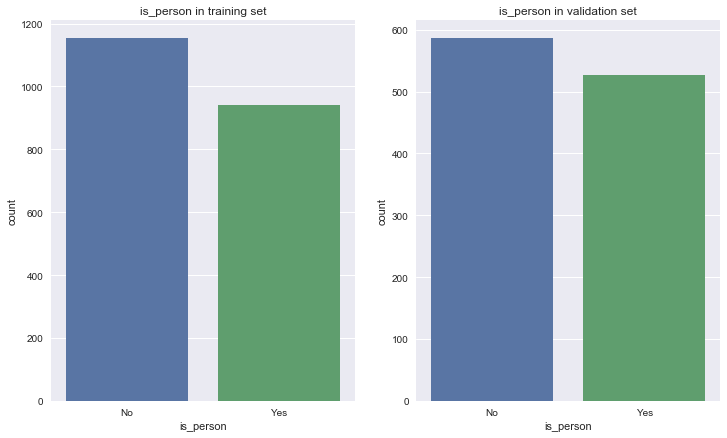

In [38]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=[12,7])
sns.countplot(y_tr ,ax=ax[0])
sns.countplot(y_val , ax=ax[1])
ax[0].set_title("is_person in training set")
ax[0].set_xticklabels(["No","Yes"])

ax[1].set_title("is_person in validation set")
ax[1].set_xticklabels(["No","Yes"])


### ========== Question 1.6 --- [1 mark] ==========
We want to make a baseline classification accuracy to beat. Pick a baseline "dummy" classifier, describe in a sentence why you chose it, and report the accuracy it achieves on the validation set?

Guess no "is_person" every time. Chosen because the likelyhood of a person not exisiting in an instance in a data set is more likely than otherwise. 

In [39]:
print("Accuracy on Validation Set: " ,1 - y_val.mean())

Accuracy on Validation Set:  0.5265049415992813


### ========== Question 1.7 --- [3 marks] ==========
Train a [`LogisticRegression`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier using default settings, except for the `solver` parameter which you should set to `lbfgs`. Report the classification accuracy score on the training and validation sets and compare with the baseline. Comment on the results with 1-2 sentences. You may include any additional plot(s) if you wish to justify your explanation.

In [40]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr, y_tr)
print('Classification accuracy on training set: {:.3f}'.format(lr.score(X_tr, y_tr)))
print('Classification accuracy on test set: {:.3f}'.format(lr.score(X_val, y_val)))

Classification accuracy on training set: 0.551
Classification accuracy on test set: 0.527


The accuracy (test set) for this model is similar to the baseline dummy classifier, as such this model does not classify new data points well.

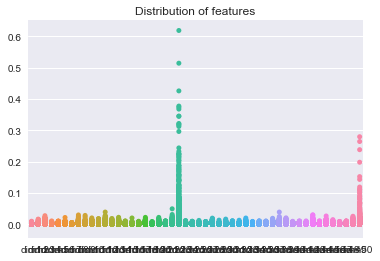

In [41]:
fig = plt.figure()
sns.stripplot(data=X_tr.drop(axis=1, labels=X_col[50:]),orient=0.5)
plt.title("Distribution of features")

Features are shown to be oddly distributed.

### ========== Question 1.8 --- [1 mark] ==========
Display the means and standard deviations of the first 5 features in the training set. *Hint: you want to compute the means and standard deviations across the columns of your arrays. Make sure you make appropriate use of the `axis` parameter.*

In [42]:
first_five = X_tr.drop(axis=1, labels=X_col[5:])
print("Means: " ,first_five.mean(axis=0))
print("STD: " ,first_five.std(axis=0))


Means:  dim1    0.001751
dim2    0.000756
dim3    0.004317
dim4    0.001853
dim5    0.002272
dtype: float64
STD:  dim1    0.001193
dim2    0.001406
dim3    0.003693
dim4    0.001340
dim5    0.001598
dtype: float64


### ========== Question 1.9 --- [3 marks] ==========
Feature standardisation is a pre-processing technique used to transform data so that they have zero mean and unit standard deviation. For many algorithms, this is a very important step for training models (both regression and classification). Read about [feature standardisation](http://scikit-learn.org/0.17/modules/preprocessing.html) and make sure you understand what kind of transformation this method applies to the data.

`Scikit-learn` offers a [class](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) for feature standardisation. Instansiate a StandardScaler object and fit it using the **training features**. Use this fitted object to transform both your training and validation features to have a standard scale. 

Once your training and validation input data have been transformed, display the means and standard deviations of the first 5 attributes for **both** the training and validation sets. Are the results as you expected? Explain your answer in 2-3 sentences. Why didn't we use the validation set to standardise the data?

**IMPORTANT: You should use the transformed data for the rest of this part.**

In [43]:
ss = StandardScaler()
ss.fit(X_tr)
X_tr_stand = ss.transform(X_tr)
X_tr_stand = pd.DataFrame(data=X_tr_stand, columns=X_col)
first_five = X_tr_stand.drop(axis=1, labels=X_col[5:])
print("Mean of Training Set: ", first_five.mean(axis=0))
print("SD of Training Set: ", first_five.std(axis=0))

Mean of Training Set:  dim1    2.206654e-17
dim2    2.208246e-16
dim3    2.682995e-16
dim4    1.608312e-16
dim5   -2.693338e-17
dtype: float64
SD of Training Set:  dim1    1.000239
dim2    1.000239
dim3    1.000239
dim4    1.000239
dim5    1.000239
dtype: float64


In [44]:
X_val_stand = ss.transform(X_val)
X_val_stand = pd.DataFrame(data=X_val_stand, columns=X_col)
first_five = X_val_stand.drop(axis=1, labels=X_col[5:])
print("Mean of Validation Set: ", first_five.mean(axis=0))
print("SD of Validation Set: ", first_five.std(axis=0))

Mean of Validation Set:  dim1   -0.005506
dim2   -0.038293
dim3    0.109151
dim4    0.093693
dim5    0.030578
dtype: float64
SD of Validation Set:  dim1    1.013564
dim2    0.970255
dim3    1.049700
dim4    1.057320
dim5    0.975152
dtype: float64


Yes they are. Although not exactly the same the transformed features (for the training set) means are ~0 and SD ~1.

The means/sd for the validation set are more varied relative to the training set as naturally the validation set is not exactly similar to the test. We do not use the validation set for fitting the transformation as it is not used in training the model, only testing it.

### ========== Question 1.10 --- [3 marks] ==========
By using the transformed input data, train a new `LogisticRegression` classifier. Again, set the `solver` parameter to `lbfgs` and use default settings for the other parameters. Report the classification accuracy on both the training and validation sets.

Comment on how your model compares to the baseline classifier from Question 1.6? You may use additional plot(s) to support your explanation.

In [45]:
lr2 = LogisticRegression(solver='lbfgs')
lr2.fit(X_tr_stand, y_tr)
print('Classification accuracy on training set: {:.3f}'.format(lr.score(X_tr_stand, y_tr)))
print('Classification accuracy on test set: {:.3f}'.format(lr.score(X_val_stand, y_val)))

Classification accuracy on training set: 0.651
Classification accuracy on test set: 0.650


It is more accurate compared to previously - reflected by the accuracy scores on the test set.

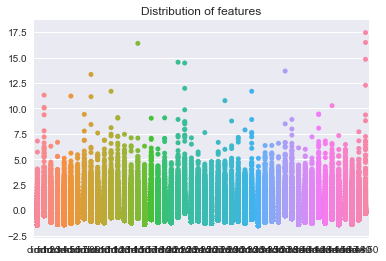

In [46]:
fig = plt.figure()
sns.stripplot(data=X_tr_stand.drop(axis=1, labels=X_col[50:]),orient=0.5)
plt.title("Distribution of features")

This plot displays that features are much more evenly distributed as compared to the previous plot. Helping and contributing properlt to the logistic regression

### ========== Question 1.11 --- [1 mark] ==========
So far we have used default settings for training the logistic regression classifier. Now, we want to use [K-fold cross-validation](http://scikit-learn.org/0.17/modules/generated/sklearn.cross_validation.KFold.html) to optimise the regularisation parameter `C`. The regularisation parameter controls the degree to which we wish to penalise large magnitudes in the weight vector. This can help us prevent overfitting but, if set too high, could lead us to underfit too.

Create a 3-fold cross-validation object. Set the `shuffle` parameter to `True` and the `random_state` to `0`. By using the cross-validation iterator, display the number of test samples for each fold.

In [47]:
kf = KFold(shuffle=True, random_state=0, n=X_tr_stand.shape[0])
for train_index, test_index in kf:
    print(len(test_index))

698
698
697


### ========== Question 1.12 --- [2 marks] ========== 
Using the cross-validation iterator from the previous question, perform a search for the best value for `C`. 

We are going to loop over each CV fold, and each value of `C`. The values of `C` to search should be 20 equally-spaced values **in log space** ranging from `1e-5` to `1e5` *(hint: look at the `logspace()` function in numpy)*. 

Create a 2-dimensional array and, for each cross-validation fold and parameter setting pair, compute and store the classification accuracy score e.g. store the score of fold 0 with parameter setting 1 at score_array[0,1]. As previously, set the `solver` parameter to `lbfgs` and use default settings for the other parameters (except for `C` obviously!).

*(hint: you could use two loops in your code; one iterating over CV folds and another one iterating over the values for `C`)*. 

In [48]:
score_array = []
n = 0

for train_index, test_index in kf:
    log_arr = np.logspace(-5,5, num=20)
    
    score_array.append([])
    for i in log_arr:
        lr2 = LogisticRegression(solver='lbfgs',C=i)
        lr2.fit(X_tr_stand.loc[train_index], y_tr[train_index])
        g = lr2.score(X_tr_stand.loc[test_index] ,y_tr[test_index]).item(0)
        score_array[n].append(g) 
        
    n += 1

### ========== Question 1.13 --- [1 mark] ========== 
Plot the mean classification performance (across CV folds) of the logistic regression classifier against the regularisation parameter `C` by using the range from Question 1.12. Use a logarithmic scale for the x-axis and label both axes appropriately. 

In [49]:
score_array = pd.DataFrame(score_array)

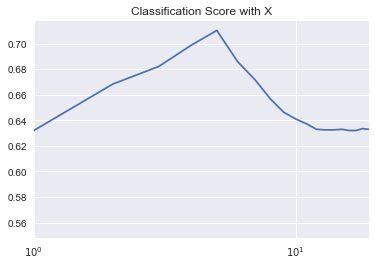

In [50]:
y = score_array.mean(axis=0)
X = np.logspace(-5,5, num=20)

df = pd.DataFrame(data=(y))
df.set_index = X


fig = plt.figure()
df.plot(logx=True,legend=False, title="Classification Score with X")


### ========== Question 1.14 --- [2 marks] ==========
Display the optimal value for the regularisation parameter `C` determined by the search results from Question 1.12. Similarly to Question 1.13, consider the mean classifiation accuracy across CV folds. By using the optimal value (i.e. the one that yields the highest average classification accuracy) train a new `LogisticRegression` classifier and report the classification accuracy on the validation set. *(Hint: Do not pick the optimal value "by hand", instead use an appropriate numpy function).*

In [51]:
high_c = X[y[y==y.max()].index[0]]
print("Highest Mean Classification C: ", high_c, " being ", y.max())

Highest Mean Classification C:  0.00428133239872  being  0.710458521238


In [52]:
lr = LogisticRegression(C=high_c, solver="lbfgs")
lr.fit(X_tr_stand,y_tr)
print("Classification Score: ", lr.score(X_val_stand,y_val))

Classification Score:  0.696316262354


### ========== Question 1.15 --- [1 mark] ========== 
Scikit-learn offers a [`LogisticRegressionCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) module which implements Logistic Regression with builtin cross-validation to find out the optimal `C` parameter. You can specify the range for the `C` parameter, as well as the cross-validation method you want to use with the `Cs` and `cv` parameters, respectively. Use the `C` range you set up in Question 1.12 and the 3-fold cross-validation iterator from Question 1.11. Once again, train the models by using the `lbfgs` optimisation method and display the optimal value for the parameter `C`. Finally, display the classification accuracy on the validation set. Check your results are consistent with those from Question 1.14!

In [53]:
lrcv = LogisticRegressionCV(solver='lbfgs',Cs=X,cv=kf)
lrcv.fit(X_tr_stand,y_tr)
print("Best C: ", lrcv.C_[0])
print("Classification Score: ", lrcv.score(X_val_stand,y_val))


Best C:  0.00428133239872
Classification Score:  0.696316262354


### ========== Question 1.16 --- [1 mark] ==========
Now, we want to validate the importance of various features for classification. For this purpose, we will use a [`RandomForestClassifier`](http://scikit-learn.org/0.17/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (you might want to refer to Lab_3 if you are unsure how we can estimate feature importances with decision tree and random forest models).

Initialise a random forest classifier and fit the model by using training data only and 500 trees (i.e. `n_estimators`). Set the `RandomState` equal to 42 to ensure reproducible results. Report the accuracy score on both the training and validation sets.

In [54]:
rfc = RandomForestClassifier(n_estimators=500,random_state=42)

In [55]:
rfc.fit(X_tr_stand, y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [56]:
print("Score on training set: ", rfc.score(X_tr_stand,y_tr))
print("Score on validation set: ", rfc.score(X_val_stand,y_val))


Score on training set:  1.0
Score on validation set:  0.692722371968


### ========== Question 1.17 --- [2 marks] ==========
Comment on the results above. Do you find the discrepancy between training and validation accuracies surprising?

Not with the discrepencies. Because in a tree classifier each of the final leaves would point to either class. Making it score/classify well on the training set but possibly overfitting. I am however, suprised that the tree could score 1.0 on the training set, getting every value correct.

### ========== Question 1.18 --- [2 marks] ==========
By using the random forest model from the previous question order the features by descending importance and display the names of the 50 most important features.

In [57]:

feature_impt= {}
x=1
for i in rfc.feature_importances_.tolist():
    feature_impt[x] = i
    x += 1

t = range(0,50)

for i in t:
    z = 0
    index = 50000
    for key,value in feature_impt.items():
        
        if (value > z):
            index = key
            z = value
    print("dim",index , ":", z)
    del feature_impt[index]



dim 21 : 0.0075719505701260965
dim 51 : 0.00755943221497452
dim 360 : 0.00703154028837957
dim 4 : 0.006192970537003059
dim 479 : 0.006054067504553028
dim 76 : 0.0060262086838827065
dim 283 : 0.005810561957774252
dim 461 : 0.005605848905356331
dim 343 : 0.00545133226506582
dim 398 : 0.004859161091117008
dim 348 : 0.004783230524237722
dim 74 : 0.004741927812981814
dim 485 : 0.004716045278998716
dim 356 : 0.004702218138277496
dim 330 : 0.004640095365072787
dim 217 : 0.004605837578784847
dim 263 : 0.004577404157967961
dim 222 : 0.004218132805352372
dim 134 : 0.004131365458194301
dim 500 : 0.004063794802420198
dim 274 : 0.0040416252061222626
dim 254 : 0.004001957922205824
dim 206 : 0.003889995873521478
dim 423 : 0.0038673852895302475
dim 347 : 0.0038130599781742995
dim 17 : 0.0037277779229481956
dim 326 : 0.003704323695578012
dim 90 : 0.003703172661177383
dim 92 : 0.0037007988101297093
dim 329 : 0.003687210362649383
dim 214 : 0.0036676459142687113
dim 322 : 0.0036134338766544553
dim 289 : 0

### ========== Question 1.19 --- [3 marks] ==========
Next, we would like to test the performance of support vector machines. Train three support vector classifiers with the following kernels: linear, radial basis function, and polynomial. Report the classification accuracy of each of the three classifiers on both the training and validation sets.

In [58]:
svm_li = SVC(kernel="linear")
svm_li.fit(X_tr_stand,y_tr)

print('LINEAR SVC classification accuracy on training set: {:.3f}'.format(svm_li.score(X_tr_stand, y_tr)))
print('LINEAR SVC classification accuracy on test set: {:.3f}'.format(svm_li.score(X_val_stand, y_val)))

svm_rbf = SVC(kernel="rbf")
svm_rbf.fit(X_tr_stand,y_tr)

print('RBF SVC classification accuracy on training set: {:.3f}'.format(svm_rbf.score(X_tr_stand, y_tr)))
print('RBF SVC classification accuracy on test set: {:.3f}'.format(svm_rbf.score(X_val_stand, y_val)))

svm_poly = SVC(kernel="poly")
svm_poly.fit(X_tr_stand,y_tr)

print('POLY SVC classification accuracy on training set: {:.3f}'.format(svm_poly.score(X_tr_stand, y_tr)))
print('POLY SVC classification accuracy on test set: {:.3f}'.format(svm_poly.score(X_val_stand, y_val)))

LINEAR SVC classification accuracy on training set: 0.842
LINEAR SVC classification accuracy on test set: 0.639
RBF SVC classification accuracy on training set: 0.911
RBF SVC classification accuracy on test set: 0.730
POLY SVC classification accuracy on training set: 0.991
POLY SVC classification accuracy on test set: 0.702


### ========== Question 1.20 --- [3 marks] ==========
At this point, we would like to get an idea of what kind of decision boundaries we can get with the three types of SVM kernels we introduced in the previous question. For visualisation, however, we can only make use of 2D input data. For this purpose, we select to use the 21st and 76th columns of our training features (*hint: remember that Python uses 0-based indexing*). 

Execute the cell below to define a useful function which we will be using to plot the decision boundaries *(it is also not a bad idea to try to understand what this functions does)*. 

Then train three distinct SVM classifiers by using the 2D input data mentioned above and default parameters:
* a linear SVC
* an RBF SVC 
* a polynomial SVC

Finally, create a list containing the three classifiers you have just trained. Use this list as an input to the provided function along with the used training features and observe the outcome. You can use the additional `title` parameter to set the titles in the subplots. Comment on the shape of the boundaries and what this means for classification accuracy in 1-2 sentences.

*(Acknowledgement: this Question has been heavily based on [this example](http://scikit-learn.org/0.17/auto_examples/svm/plot_iris.html) from scikit-learn's documentation.)*

In [59]:
def show_svc_decision_boundaries(clfs, X, title=None):
    """Plots decision boundaries for classifiers with 2D inputs.
    
    Parameters
    ----------
    clf : list
        Classifiers for which decision boundaries will be displayed.
    X : array
        Input features used to train the classifiers.
    title : list, optional
        Titles for classifiers.
    
    """
    
    assert X.shape[1] == 2 # Input should be 2D
    if title is not None:
        assert len(clfs) == len(title)
    
    h = .04 # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    plt.figure(figsize=(15,5))
    for i, clf in enumerate(clfs):
        plt.subplot(1, len(clfs), i + 1)
        plt.subplots_adjust(wspace=0.4, hspace=0.4)
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
        # Training points
        plt.scatter(X[:, 0], X[:, 1], c=y_tr, cmap=plt.cm.Paired)
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        if title is not None:
            plt.title(title[i])

In [60]:
svm_X_input = X_tr_stand[[X_col[20], X_col[75]]]

svm_li = SVC(kernel="linear")
svm_li.fit(svm_X_input,y_tr)

svm_rbf = SVC(kernel="rbf")
svm_rbf.fit(svm_X_input,y_tr)

svm_poly = SVC(kernel="poly")
svm_poly.fit(svm_X_input,y_tr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

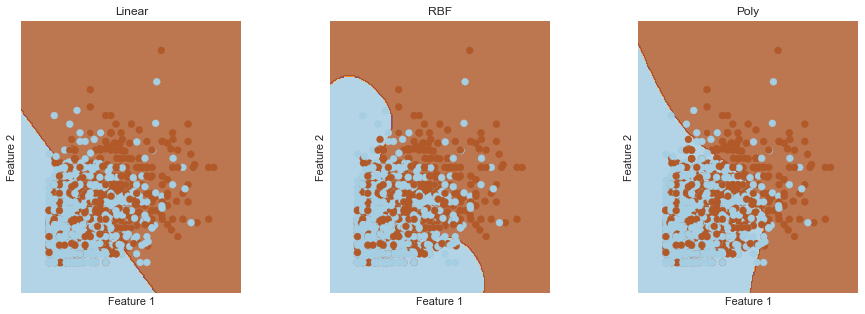

In [61]:
svm_cl = [svm_li,svm_rbf,svm_poly]

#svm_X_input = np.array([X_tr_stand[X_col[20]].values, X_tr_stand[X_col[75]].values])
#svm_X_input = svm_X_input.reshape(2093,2)

               
show_svc_decision_boundaries(svm_cl, svm_X_input.values,["Linear","RBF","Poly"])

The shapes of the decision boundaries of linear, rbf and poly are as expected to their basis functions. 

The RBF and Poly kernals shift the decision boundary such that it can accomodate a different distribution of class points relative to linear. This allows it to better fit its training set. It seems as if Poly has overfit the training set, not performing as well as RBF.

### ========== Question 1.21 --- [5 marks] ==========
So far we have used default parameters for training the SVM classifiers. Now we want to tune the parameters by using cross-validation. 

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of an SVM classifier with RBF kernel, while you vary the penalty parameter `C` in a logarithmic range `np.logspace(-2, 3, 10)`. Set the kernel coefficient parameter `gamma` to `auto` for this question. 

Plot the mean cross-validated classification accuracy against the regularisation parameter `C` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `C` which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [62]:
range_c = np.logspace(-2, 3, 10)
score_array = []
i=0
for train_index, test_index in kf:
    score_array.append([])
    for c in range_c:
        svm_rbf = SVC(kernel="rbf", C=c,gamma="auto")
        svm_rbf.fit(X_tr_stand.iloc[train_index], y_tr[train_index])
        score_array[i].append(svm_rbf.score(X_tr_stand.iloc[test_index],y_tr[test_index]))
    i+= 1


In [63]:
score_array = pd.DataFrame(score_array)
mean_score = score_array.mean(axis=0)

X = np.logspace(-2,3,10)
highest_mean_score = mean_score.max()
highest_c =  X[mean_score[mean_score==mean_score.max()].index[0]]
print("Best C: ",highest_c, "with a mean score of : ", highest_mean_score )

Best C:  1.6681005372 with a mean score of :  0.715230644637


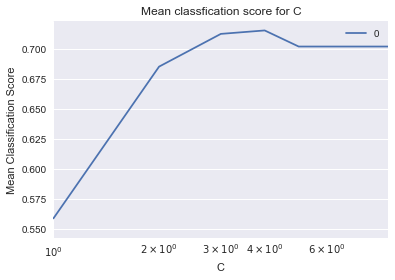

In [64]:
fig = plt.figure() 
df = pd.DataFrame(mean_score)
df.set_index(X)
df.plot(logx=True,title="Mean classfication score for C")
plt.xlabel("C")
plt.ylabel("Mean Classification Score")

In [65]:
svm_rbf = SVC(kernel="rbf", C=highest_c,gamma="auto")
svm_rbf.fit(X_tr_stand, y_tr)

print("Classification Score on training set: " , svm_rbf.score(X_tr_stand,y_tr))
print("Classification Score on validation set: " , svm_rbf.score(X_val_stand,y_val))

Classification Score on training set:  0.974677496417
Classification Score on validation set:  0.727762803235


### ========== Question 1.22 --- [5 marks] ==========
Now we turn to the kernel coefficient `gamma` parameter. By using the same procedure as in the previous question, estimate the classification accuracy of an SVM classifier with RBF kernel while you vary the `gamma` parameter in a logarithmic range `logspace(-5, 0, 10)`. Fix the penalty parameter `C=1.0`.

Plot the mean cross-validated classification accuracy against the parameter `gamma` by using a log-scale for the x-axis. Display the highest obtained mean accuracy score and the value of `gamma` which yielded it.  Label axes appropriately.

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [66]:
i = 0
score_array = []
X = np.logspace(-5,0,10)
for train_index, test_index in kf:
    score_array.append([])
    for gam in X:
        svm_rbf = SVC(C=1.0, kernel="rbf", gamma=gam)
        svm_rbf.fit(X_tr_stand.iloc[train_index],y_tr[train_index])
        
        score_array[i].append(svm_rbf.score(X_tr_stand.iloc[test_index],y_tr[test_index]))
    i+=1


In [67]:
score_array = pd.DataFrame(score_array)
mean_score = score_array.mean(axis=0)

X = np.logspace(-5,0,10)
highest_mean_score = mean_score.max()
highest_g =  X[mean_score[mean_score==mean_score.max()].index[0]]
print("Best gamma: ",highest_g, "with a mean score of : ", highest_mean_score )

Best gamma:  0.0016681005372 with a mean score of :  0.716185754475


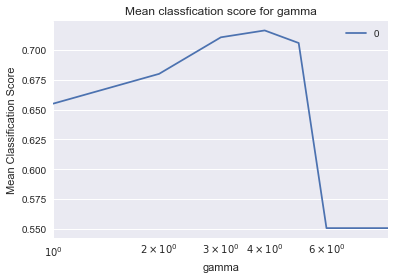

In [68]:
fig = plt.figure() 
df = pd.DataFrame(mean_score)
df.set_index(X)
df.plot(logx=True,title="Mean classfication score for gamma")
plt.xlabel("gamma")
plt.ylabel("Mean Classification Score")

In [69]:
svm_rbf = SVC(kernel="rbf", C=1.0,gamma=highest_g)
svm_rbf.fit(X_tr_stand, y_tr)

print("Classification Score on training set: " , svm_rbf.score(X_tr_stand,y_tr))
print("Classification Score on validation set: " , svm_rbf.score(X_val_stand,y_val))

Classification Score on training set:  0.891065456283
Classification Score on validation set:  0.726864330638


### ========== Question 1.23 --- [7 marks] ==========
Now we wish to tune both the `C` and `gamma` parameters simultaneously. To save computational time, we will now constrain the parameter search space. Define a `4 X 4` grid for the two parameters, as follows:
* `C`: `np.logspace(-2, 1, 4)`
* `gamma`: `np.logspace(-4, -1, 4)`

Estimate the mean cross-validated classification accuracy by using training data only and all possible configurations for the two parameters. 

Use a [heatmap](https://seaborn.github.io/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap) to visualise the mean cross-validated classification accuracy for all `C`-`gamma` pairs. Label axes appropriately and display the values for `C` and `gamma` for the best performing configuration. 

Finally, by using the optimal configuration, train a classifier (without using cross-validation) and report the classification accuracy on the training and validation sets.

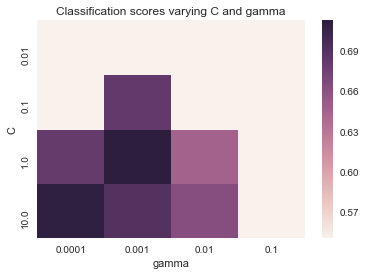

In [70]:
score_array = []
i = 0
X_c = np.logspace(-2, 1, 4)
X_g = np.logspace(-4, -1, 4)
for train_index, test_index in kf:
    score_array.append([])
    t=0
    
    for c in X_c:
        score_array[i].append([])
        for g in X_g:
            svm_rbf = SVC(kernel="rbf", C=c,gamma=g)
            svm_rbf.fit(X_tr_stand.iloc[train_index],y_tr[train_index])
            score_array[i][t].append(svm_rbf.score(X_tr_stand.iloc[test_index],y_tr[test_index]))
        
        t+=1
    i+=1


def get_score(score_array,row,col):
    ans = 0
    for instance_index, instance in enumerate(score_array):
        ans += score_array[instance_index][row][col]
    return ans/len(score_array)

mean_score = []
i=0
for c_index, c in enumerate(X_c):
    mean_score.append([])
    for g_index, g in enumerate(X_g):
        
        mean_score[i].append(get_score(score_array,c_index,g_index))
    i+=1


fig = plt.figure()
df = pd.DataFrame(mean_score)
df.columns= X_g
df.set_index(X_c,inplace=True)

sns.heatmap(data=df)
plt.title("Classification scores varying C and gamma")
plt.xlabel("gamma")
plt.ylabel("C")

In [71]:
best_score = df.max().max()
s = df.stack()
t = s[s==best_score]
highest_c = t.index.tolist()[0][0]
highest_g =   t.index.tolist()[0][1]

print("Best classification score:" ,best_score,"with c: " , highest_c, "and g: ", highest_g)


Best classification score: 0.712362574494 with c:  1.0 and g:  0.001


In [72]:
svm_rbf = SVC(kernel="rbf", C=highest_c,gamma=highest_g)
svm_rbf.fit(X_tr_stand, y_tr)

print("Classification Score on training set: " , svm_rbf.score(X_tr_stand,y_tr))
print("Classification Score on validation set: " , svm_rbf.score(X_val_stand,y_val))

Classification Score on training set:  0.834687052078
Classification Score on validation set:  0.721473495058


### ========== Question 1.24 --- [3 marks] ==========
Is the classification accuracy on the validation set higher than in previous questions (1.22-1.23)? If not, can you explain why? Can you think of a way of further improving the performance of the classifier? You don't need to implement your suggestion at this stage. Would there be any associated problems with your suggested approach? 

No. It is lower. yes, by running through more parameters/combinations of C and gamma to get better parameters. I believe that the classification score actually decreased because we tried fewer parameters of C as compared to previously.

Yes. Computing time would be much higher

### ========== Question 1.25 --- [5 marks] ==========
Now we want to evaluate the performance of an SVM classifier with polynomial kernel. Once again, we will tune the `degree` parameter by using cross-validation (similarly to what we did in Questions 1.21 and 1.22).

By using the `K-fold` iterator from Question 1.11 and training data only, estimate the classification accuracy of polynomial SVM classifier, while you vary the `degree` parameter in the range `np.arange(1,8)`. 

Plot the mean cross-validated classification accuracy against the polynomial degree. Display the highest obtained mean accuracy score and the value of the `degree` parameter which yielded it. Label axes appropriately. 

Finally, train a classifier by using the optimal value for this parameter (without using cross-validation at this stage) and report the classification accuracy on the training and validation sets. 

In [73]:
i = 0
score_array = []
X = np.arange(1,8)
for train_index, test_index in kf:
    score_array.append([])
    for deg in X:
        svm_poly = SVC( kernel="poly", degree=deg)
        svm_poly.fit(X_tr_stand.iloc[train_index],y_tr[train_index])
        
        score_array[i].append(svm_poly.score(X_tr_stand.iloc[test_index],y_tr[test_index]))
    i+=1


In [74]:
score_array = pd.DataFrame(score_array)
mean_score = score_array.mean(axis=0)

highest_mean_score = mean_score.max()
highest_g =  X[mean_score[mean_score==mean_score.max()].index[0]]
print("Best degree: ",highest_g, "with a mean score of : ", highest_mean_score )

Best degree:  1 with a mean score of :  0.702810105802


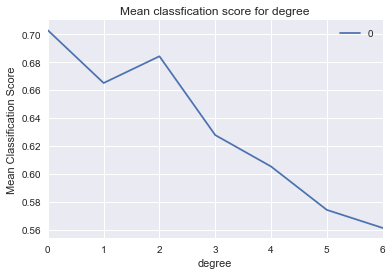

In [75]:
fig = plt.figure() 
df = pd.DataFrame(mean_score)
df.set_index(X)
df.plot(title="Mean classfication score for degree")
plt.xlabel("degree")
plt.ylabel("Mean Classification Score")
plt.show()

In [76]:
svm_poly = SVC( kernel="poly", degree=highest_g)
svm_poly.fit(X_tr_stand,y_tr)

print("Classification Score on training set: " , svm_poly.score(X_tr_stand,y_tr))
print("Classification Score on validation set: " , svm_poly.score(X_val_stand,y_val))

Classification Score on training set:  0.783564261825
Classification Score on validation set:  0.689128481581


### ========== Question 1.26 --- [4 marks] ==========

You might have noticted that so far, we have used cross-validation for optimising the various tuning parameters (e.g. regularisation parameter in logistic regression, SVM kernel parameters) rather than hold-out validation, although we did have access to a validation set. Why do you think this is a good/bad idea? Give one advantage and one disadvantage of the two different approaches. Which one would you trust more in practice?

Hold-out validation:
advantage - lower computing time as you only need to run the model once

disadvantage - performance evaluation is subject to higher variance due to a "smaller" data set

cross-validation:
advantage - lower variance on performance evaluation

disadvantage - much higher computing costs, harder to debug

i would trust cross-validation more to come up with my parameters due to its advantage of lower variance on performance evaluation

### ========== Question 1.27 --- [6 marks] ==========

Reload the full training and validation data that contain all indicator variables for all object categories. Remove the `imgId` attribute but keep all of the class indicator variables in the dataset this time. Your training features should include all attributes except `is_person` which should be your target variable. 

Once again, use a [StandardScaler](http://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.StandardScaler.html) to standardise your training and validation features. Then train a Random Forest Classifier by using the entropy `criterion`, 500 `n_estimators`, and also set the `random_state` to 31. Report the classification accuracy on the training and validation sets.

Similarly to what we did in Question 1.18, order the features by decreasing importance and display the 50 most important features. 

Finally, answer the following questions:
* What do you notice by looking at the list of the best 50 features?
* How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.
* Would it be easy to make use of the results in practice? Briey explain your reasoning.

*(Hint: you might want to look at some of the [images](http://www.inf.ed.ac.uk/teaching/courses/iaml/2014/assts/asst3/images.html) to justify your explanations.)*

In [77]:
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partA.csv')
train_A = pd.read_csv(data_path, delimiter = ',')
print('train_A | Number of instances: {}, number of attributes: {}'.format(train_A.shape[0], train_A.shape[1]))

data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partA.csv')
valid_A = pd.read_csv(data_path, delimiter = ',')
print('valid_A | Number of instances: {}, number of attributes: {}'.format(valid_A.shape[0], valid_A.shape[1]))


train_A | Number of instances: 2093, number of attributes: 520
valid_A | Number of instances: 1113, number of attributes: 520


In [78]:
train_A_indexed = train_A.drop("imgId",axis=1)
valid_A_indexed = valid_A.drop("imgId",axis=1)

X_tr = train_A_indexed.drop("is_person",axis=1)
X_val = valid_A_indexed.drop("is_person",axis=1)
y_tr = train_A_indexed["is_person"]
y_val = valid_A_indexed["is_person"]



In [79]:
X_col = X_tr.columns.values.tolist()
ss = StandardScaler()
ss.fit(X_tr)
X_tr_stand = ss.transform(X_tr)
X_tr_stand = pd.DataFrame(data=X_tr_stand, columns=X_col)

X_val_stand = ss.transform(X_val)
X_val_stand = pd.DataFrame(data=X_val_stand, columns=X_col)


In [80]:
rfc = RandomForestClassifier(criterion="entropy", n_estimators=500,random_state=31)
rfc.fit(X=X_tr_stand,y=y_tr)
print("Classification score with training set: " , rfc.score(X_tr_stand,y_tr))
print("Classifcation score with test set: " , rfc.score(X_val_stand,y_val))

Classification score with training set:  1.0
Classifcation score with test set:  0.711590296496


In [81]:
feature_impt= {}
x=0
for i in rfc.feature_importances_.tolist():
    feature_impt[x] = i
    x += 1

t = range(0,50)

for i in t:
    z = 0
    index = 50000
    for key,value in feature_impt.items():
        
        if (value > z):
            index = key
            z = value
    print(X_col[index] , ":", z)
    del feature_impt[index]

is_cat : 0.009378660464170746
is_bird : 0.008730905617523231
dim21 : 0.008030268242118669
dim51 : 0.005924593779591833
dim360 : 0.005463270730147453
dim4 : 0.005325463573024001
dim76 : 0.005271109427699043
dim398 : 0.005254291293471388
dim283 : 0.004982521468726957
dim479 : 0.004941770916921759
dim263 : 0.004733840538947801
dim343 : 0.004609191127087782
dim423 : 0.004433294145917714
dim485 : 0.004244690009363214
dim254 : 0.004188582305401224
dim461 : 0.004157503978723529
dim222 : 0.004134377135817939
dim356 : 0.0039138875860249295
dim74 : 0.0038603367481714335
dim288 : 0.003850365683691205
dim214 : 0.0037915869326592007
dim348 : 0.0037810959049539117
dim330 : 0.003712548531421811
dim217 : 0.003683426786554175
dim483 : 0.00363277470755832
dim90 : 0.0036258903666367714
dim274 : 0.0035970303119618125
dim347 : 0.0035330997133573776
dim17 : 0.003447608315671807
dim427 : 0.0033773881272774462
dim35 : 0.003305822073970323
dim326 : 0.0032983574618096344
dim73 : 0.0032667142601207795
dim312 : 0

What do you notice by looking at the list of the best 50 features?

The top two features are not visual bags of words, but whether there exists a cat (is_cat) or bird (is_bird)

How does the performance differ with respect to the case when the additional class indicator variables are not present (Question 1.16)? Relate your observations to the observed feature ranking.

It performs better with a score with the test set of 0.711 compared to 0.692722371968. This is expected as the top two features of "is_person" in the random forest generator are the new features that were added.

Would it be easy to make use of the results in practice? Briey explain your reasoning.

In practice, one would have to identify if pictures had an cat/bird/other item in a data set for these features to be available. You would either have a human do this or another model (with its own accuracy). Also using these as features causes the model to base its predictions on the existance of another entity rather than the visual cues in the image itself. As such the practicality of using these as featuers is not high.

## Mini challenge [30%]

*Important: You are allowed to write up to a maximum of 600 words in this part of the assignment. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final classification performance of your chosen method(s) and credit will be divided accordingly.*

In this final part of the assignment we will have a mini object-recognition challenge. Using the data provided you are asked to find the best classiffier for the person/no person classification task. You can apply any preprocessing steps to the data that you think fit and employ any classifier you like (with the provison that you can explain what the classifier is/preprocessing steps are doing). You can also employ any lessons learnt during the course, either from previous Assignments, the Labs or the lecture material to try and squeeze out as much performance as you possibly can. The only restriction is that all steps must be performed in `Python` by using the `numpy`, `pandas` and `sklearn` packages. You can also make use of `matplotlib` and `seaborn` for visualisation. 

**Important:** The classification performance metric that we will use for this part is the *cross-entropy* or *logarithmic loss* (see Lab 4). You should familiarise yourself with the metric by reading the `sklearn` [user guide](http://scikit-learn.org/0.17/modules/model_evaluation.html#log-loss) and [documentation](http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss). To estimate this metric you will need to evaluate probability outputs, as opposed to discrete predictions which we have used so far to compute classification accuracies. Most models in `sklearn` implement a `predict_proba()` method which returns the probabilities for each class. For instance, if your test set consists of `N` datapoints and there are `K` classes, the method will return a `N` x `K` matrix.

We provide you with three new data sets: a training set (`train_images_partB.csv`), a validation set (`valid_images_partB.csv`), and a test set (`test_images_partB.csv`). You must use the former two for training and evaluating your models (as you see fit). Once you have chosen your favourite model (and pre-processing steps) you should apply it to the test set (for which no labels are provided). Estimate the posterior proabilities for the data points in the test set and submit your results as part of your answer. Your results will be evaluated in terms of the logarithmic loss metric. You also need to submit a brief description of the approaches you considered, your suggested final approach, and a short explanation of why you chose it. The thoroughness of the exploration and the quality of the resulting discussion is just as important as the final score of your chosen method(s) and credit will be divided accordingly.

*Hint: Feature engineering, feature combination, model combination and model parameter optimization can significantly improve performance.*

**How to submit your results**: Store the estimated probabilities for the data points in the test set in a 2D numpy array. Then execute the provided cell at the end of this notebook which uses a provided `save_predictions` function to export your results into a `.txt` file (the function will return an error if the provided array has not the right shape). The `.txt` file will be saved where your notebook lives. Submit this file along with your notebook as detailed at the top of this file.

*Your answer goes here (max. 600 words)*



In [113]:
data_path = os.path.join(os.getcwd(), 'datasets', 'train_images_partB.csv')
train_B = pd.read_csv(data_path, delimiter = ',')
print('train_B | Number of instances: {}, number of attributes: {}'.format(train_A.shape[0], train_A.shape[1]))

data_path = os.path.join(os.getcwd(), 'datasets', 'valid_images_partB.csv')
valid_B = pd.read_csv(data_path, delimiter = ',')
print('valid_B | Number of instances: {}, number of attributes: {}'.format(valid_A.shape[0], valid_A.shape[1]))


data_path = os.path.join(os.getcwd(), 'datasets', 'test_images_partB.csv')
test_B = pd.read_csv(data_path, delimiter = ',')
print('test_B | Number of instances: {}, number of attributes: {}'.format(valid_A.shape[0], valid_A.shape[1]))

train_B | Number of instances: 2093, number of attributes: 520
valid_B | Number of instances: 1113, number of attributes: 520
test_B | Number of instances: 1113, number of attributes: 520


In [114]:
#creating X_col, list of feature names used
X_col = train_B.drop("imgId", axis=1).columns.values.tolist()
X_col = X_col[:500]

In [123]:
#creating training and validation inputs
X_tr = train_B[X_col]
X_val = valid_B[X_col]
X_test = test_B[X_col]

y_tr = train_B["is_person"]
y_val = valid_B["is_person"]

Here im going with using less data (removing the  "is_something" features ) to determine "is_person" as I would like my model to be based on visual cues in an image rather than the presence of another entity/object. From here I start exploring the data...

In [116]:
print("feature mean, mean: ", X_tr.mean().mean())
print("feature std, mean: ", X_tr.std().mean())
print("feature max, mean: ", X_tr.max().mean())

print("feature mean, std: ", X_tr.mean().std())
print("feature std, std: ", X_tr.std().std())
print("feature max, std: ", X_tr.max().std())
print("feature max, std: ", X_tr.min().std())

feature mean, mean:  0.048840763630856356
feature std, mean:  0.5528484210911909
feature max, mean:  9.505181348
feature mean, std:  0.006192086683722825
feature std, std:  0.057406488869649885
feature max, std:  0.4944422841263389
feature max, std:  0.0


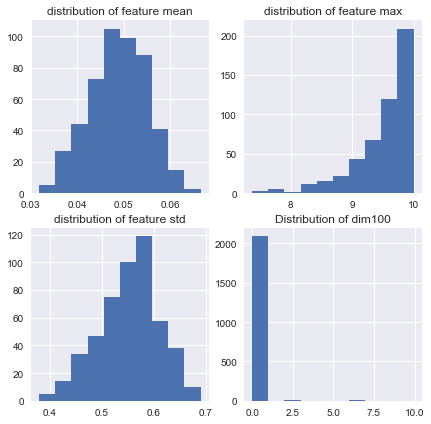

In [117]:
fig, ax = plt.subplots(2,2,figsize=(7,7))
ax[0,0].hist(X_tr.mean())
ax[0,0].set_title("distribution of feature mean")
ax[0,1].hist(X_tr.max())
ax[0,1].set_title("distribution of feature max")
ax[1,0].hist(X_tr.std())
ax[1,0].set_title("distribution of feature std")

ax[1,1].hist(X_tr["dim100"])
ax[1,1].set_title("Distribution of dim100")
plt.show()


Taking a look at how similar the features are to one another in the dataset. I notice that thier means and std are somewhat similar. however it seems that thier max's are quite high indicating a skewed distribution - not a good input into any model. first i want to fix individual feature distribution.

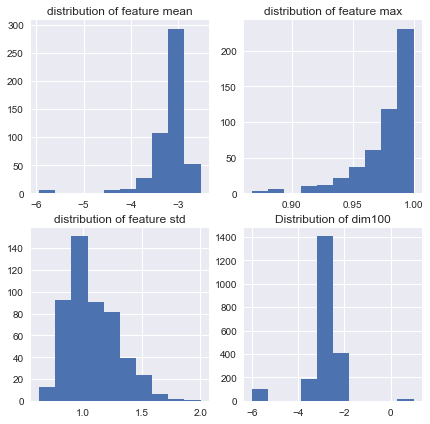

In [124]:
X_tr_log = np.log10(X_tr +0.000001)
X_val_log = np.log10(X_val+0.000001)
X_test_log =  np.log10(X_test+0.000001)
fig, ax = plt.subplots(2,2,figsize=(7,7))
ax[0,0].hist(X_tr_log.mean())
ax[0,0].set_title("distribution of feature mean")
ax[0,1].hist(X_tr_log.max())
ax[0,1].set_title("distribution of feature max")
ax[1,0].hist(X_tr_log.std())
ax[1,0].set_title("distribution of feature std")

ax[1,1].hist(X_tr_log["dim100"])
ax[1,1].set_title("Distribution of dim100")
plt.show()


Much better (distribution of dim100). A small amount is added to each value to allow for the transformation. Next lets next standardise because we want each attribute to matter equally in our classifiers also for gradient decent to run faster...

In [125]:
ss = StandardScaler()
ss.fit(X_tr_log)

X_tr_stand = ss.transform(X_tr_log)
X_val_stand = ss.transform(X_val_log)
X_test_stand = ss.transform(X_test_log)
X_tr_stand = pd.DataFrame(X_tr_stand,columns=X_col)
X_val_stand = pd.DataFrame(X_val_stand,columns=X_col)


Now becuase the cost method is log loss...

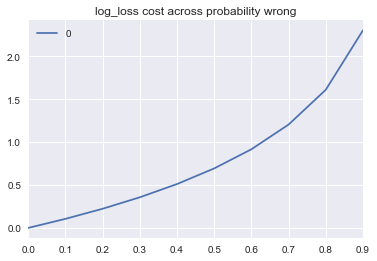

In [120]:
test_y = np.arange(0.0,1.0,0.1)
score_array= []
for i in test_y:
    y_true = [1]
    y_pred = [[i,1.0-i]]
    score_array.append(log_loss(y_true,y_pred,labels=[0,1]))
    
fig = plt.figure()
df = pd.DataFrame(score_array)
df = df.set_index(test_y)
df.plot()
plt.title("log_loss cost across probability wrong")
plt.show()

And it increases exponentially the more "wrong" you are with regards to a sample. I predict that a logistic regression model would best suit the cost function. This is because relative to other classifiers, (to my knowledge) like SVMs or random forest, logistic regression takes into account confidence and probabilities of every point as compared to an SVM which ultimately only considers the support vectors, generalizing other input points. 

In [121]:
X_tr_stand

,dim1,dim2,dim3,dim4,dim5,dim6,dim7,dim8,dim9,dim10,...,dim491,dim492,dim493,dim494,dim495,dim496,dim497,dim498,dim499,dim500
0,0.372072,0.667646,0.150663,-0.111078,0.078602,0.199113,0.489052,0.394310,0.554860,0.690377,...,-0.020413,0.886792,0.541661,0.170548,0.313099,-0.230942,0.728900,0.153837,0.083164,-0.531366
1,0.194055,0.568110,0.557385,0.585730,0.532445,0.685918,0.615545,0.411951,0.274015,0.097433,...,0.239137,-0.884539,0.677802,0.191630,0.646213,0.605581,0.134810,-4.272544,0.391825,0.524090
2,-0.354510,-1.106663,-3.148304,-0.004766,0.041861,0.747378,0.119019,0.369418,0.557230,0.605291,...,0.269031,-0.884539,-0.181299,-0.157295,-0.092482,-3.675001,-2.787503,-0.617205,0.468083,-3.671090
3,0.515831,1.056087,0.346031,-0.504305,-0.726241,0.267130,-2.234901,0.578378,-3.165109,0.166563,...,0.113002,-0.884539,0.871228,-0.003997,-0.287978,-0.291132,-0.434722,0.125352,-3.589250,0.065554
4,0.124187,0.529018,-0.148257,-0.547879,-0.033031,0.220813,0.689575,-2.385233,0.525135,0.384021,...,0.258900,0.941657,-2.132853,0.255377,-0.507966,0.534015,0.790846,0.532594,-0.362793,0.020353
5,-3.482766,1.348105,-0.686153,-0.504305,-0.726241,-0.644841,0.252827,0.862577,-0.477589,-0.760325,...,-0.529470,1.531068,-0.070363,-2.854078,-4.536440,-3.675001,-2.787503,-0.172832,-0.659866,-0.732159
6,-0.567364,-1.106663,0.341537,-0.547879,-0.404454,0.780518,0.479225,0.465159,0.477287,0.627384,...,-0.250760,-0.884539,0.370034,0.255377,-0.211255,-0.337843,0.698059,0.268796,0.256736,-0.232882
7,-0.117879,1.056087,-0.805397,-0.643627,-0.292501,-3.662579,-0.115286,0.790209,-3.165109,-3.827422,...,-0.341701,1.274581,0.467955,-2.854078,-4.536440,-0.230942,-2.787503,-0.981051,-0.801739,0.396873
8,0.403734,0.917012,0.372284,-0.015598,0.508607,0.014431,0.371008,0.611313,0.525135,0.025004,...,0.070943,0.941657,0.634219,0.255377,-0.015494,0.302943,0.480893,0.178710,0.380945,0.187431
9,-0.019627,0.529018,0.499287,0.232276,-0.033031,0.529551,-2.234901,0.611313,-3.165109,0.329415,...,0.330477,-0.884539,0.333275,0.496366,0.387336,0.302943,-0.196124,0.415462,0.090202,0.312044


In [122]:
lr = LogisticRegressionCV(Cs=20, cv=5, solver="lbfgs", random_state=10)
lr.fit(X_tr_stand,y_tr)

print("Value of C:", lr.C_)
print("Normal Classification score on training: ", lr.score(X_tr_stand,y_tr))
print("Normal Classification score on test: ", lr.score(X_val_stand,y_val))
print("Log loss score: ", log_loss(y_val,lr.predict_proba(X_val_stand)))

Value of C: [ 0.00069519]
Normal Classification score on training:  0.734027449124
Normal Classification score on test:  0.674752920036
Log loss score:  0.616736695899


The log-loss score seems somewhat high... the classification score seems bad

In [ ]:
kf = KFold(n=X_tr.shape[0],n_folds=3)

In [ ]:
#for rbf
score_array = []
i = 0
X_c = np.logspace(-2, 4, 10)
X_g = np.logspace(-4, 0, 10)
for train_index, test_index in kf:
    score_array.append([])
    t=0
    
    for c in X_c:
        score_array[i].append([])
        for g in X_g:
            svm_rbf = SVC(kernel="rbf", C=c,gamma=g,probability=True)
            svm_rbf.fit(X_tr_stand.iloc[train_index],y_tr[train_index])
            score_array[i][t].append(log_loss(y_tr[test_index],svm_rbf.predict_proba(X_tr_stand.iloc[test_index])))
        
        t+=1
    i+=1


def get_score(score_array,row,col):
    ans = 0
    for instance_index, instance in enumerate(score_array):
        ans += score_array[instance_index][row][col]
    return ans/len(score_array)

mean_score = []
i=0
for c_index, c in enumerate(X_c):
    mean_score.append([])
    for g_index, g in enumerate(X_g):
        
        mean_score[i].append(get_score(score_array,c_index,g_index))
    i+=1


fig = plt.figure()
df = pd.DataFrame(mean_score)
df.columns= X_g
df.set_index(X_c,inplace=True)

sns.heatmap(data=df)
plt.title("Log_loss scores varying C and gamma")
plt.xlabel("gamma")
plt.ylabel("C")

In [ ]:
best_score = df.min().min()
s = df.stack()
t = s[s==best_score]
highest_c = t.index.tolist()[0][0]
highest_g =   t.index.tolist()[0][1]

print("Best log_loss score:" ,best_score,"with c: " , highest_c, "and g: ", highest_g)

In [ ]:
svm_rbf = SVC(kernel="rbf", C=highest_c,gamma=highest_g,probability=True)
svm_rbf.fit(X_tr_stand, y_tr)

print("Classification Score on training set: " , svm_rbf.score(X_tr_stand,y_tr))
print("Classification Score on validation set: " , svm_rbf.score(X_val_stand,y_val))
print("Log loss score: ", log_loss(y_val,svm_rbf.predict_proba(X_val_stand)))

In [ ]:
i = 0
score_array = []
X = np.arange(1,8)
for train_index, test_index in kf:
    score_array.append([])
    for deg in X:
        svm_poly = SVC( kernel="poly", degree=deg)
        svm_poly.fit(X_tr_stand.iloc[train_index],y_tr[train_index])
        
        score_array[i].append(log_loss(y_tr[test_index],svm_rbf.predict_proba(X_tr_stand.iloc[test_index])))
    i+=1


In [ ]:
score_array = pd.DataFrame(score_array)
mean_score = score_array.mean(axis=0)

highest_mean_score = mean_score.min()
highest_g =  X[mean_score[mean_score==mean_score.max()].index[0]]
print("Best degree: ",highest_g, "with a mean score of : ", highest_mean_score )

In [ ]:
fig = plt.figure() 
df = pd.DataFrame(mean_score)
df.set_index(X)
df.plot(title="Mean classfication score for degree")
plt.xlabel("degree")
plt.ylabel("Mean Classification Score")
plt.show()

In [ ]:
score_array

(1113, 2)

In [127]:
# Execute this cell to export your results
from numpy import savetxt
def save_predictions(pred_proba):
    if pred_proba.shape != (1114,2):
        raise ValueError('Predicted probabilities array is not the right shape.')
    
    savetxt('assignment_3_predictions.txt', pred_proba)

# You need to replace "test_images_partB_pred_proba"
# with the name of the array which contains the probability 
# estimates for the data in the test set.
save_predictions(lr.predict_proba(X_test_stand))

# Appendix

## More information about visual words

Visual words are based on [Scale-invariant feature transforms (SIFT)](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform). SIFT features are essentially local orientation histograms and capture the properties of small image regions. They possess attractive invariance properties which make them well suited for our task (you can read more about SIFT features in [D.Lowe, IJCV 60(2):91- 110, 2004](http://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), but the details don't matter for the purpose of this assignment). Each SIFT feature is a 128 dimensional vector. From each image many SIFT features are extracted, typically > 2500 per image (features are extracted at regular intervals using a 15 pixel grid and at 4 different scales). To obtain visual words a representative subset of all extracted SIFT features from all images is chosen and clustered with k-means using 500 centres (such use of the k-means algorithm will be discussed in detail during the lecture). These 500 cluster centres form our visual words. The representation of a single image is obtained by first assigning each SIFT feature extracted from the image to the appropriate cluster (i.e. we determine the visual word corresponding to each feature by picking the closest cluster centre). We then count the number of features from that image assigned to each cluster (i.e. we determine how often each visual word is present in the image). This results in a 500 dimensional count vector for each image (one dimension for each visual word). The normalized version of this count vector gives the final representation of the image (normalized means that we divide the count vector by the total number of visual words in the image, i.e. the normalized counts sum to 1 for each image)